# ADS 509 Team 1 Project - Tesla vs Toyota News Articles
### By: Jesse Gutierrez, Roger Qiu, Shailja Somani

link: https://newsapi.org/

newsapi key: d6995599193044b0a5f954c098da84d6

## Part 1. API retrival, pre-processing and EDA

### Install and add imports

In [1]:
pip install newsapi-python

Note: you may need to restart the kernel to use updated packages.


In [6]:
from newsapi import NewsApiClient
import pandas as pd
import numpy as np
import os
import requests
import matplotlib.pyplot as plt
import regex as re
from datetime import datetime, timedelta
import nltk
from textblob import TextBlob
import itertools
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from sklearn.pipeline import Pipeline
nltk.download('stopwords')

from collections import Counter

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


### Check the newsAPI data source

In [7]:
# use API key to initialize newsapi client
newsapi = NewsApiClient(api_key='d6995599193044b0a5f954c098da84d6')
newsapi

In [8]:
# check what the top headlines data looks like
top_headlines = newsapi.get_top_headlines(q='world',
                                          category='business',
                                          language='en',
                                          country='us')

top_headlines                                    

{'status': 'ok',
 'totalResults': 2,
 'articles': [{'source': {'id': None, 'name': 'CNBC'},
   'author': 'MacKenzie Sigalos',
   'title': 'Bitcoin drops to $67,000 level, and Gemini returns more than $2 billion to users - CNBC',
   'description': "CNBC Crypto World features the latest news and daily trading updates from the digital currency markets and provides viewers with a look at what's ahead with high-profile interviews, explainers, and unique stories from the ever-changing crypto industry. On tod…",
   'url': 'https://www.cnbc.com/video/2024/05/29/bitcoin-drops-to-67000-level-and-gemini-returns-more-than-2-billion-to-users-cnbc-crypto-world.html',
   'urlToImage': 'https://image.cnbcfm.com/api/v1/image/107421538-0529_CW_THUMB.jpg?v=1717009856&w=1920&h=1080',
   'publishedAt': '2024-05-29T19:11:00Z',
   'content': None},
  {'source': {'id': None, 'name': 'WSB Atlanta'},
   'author': 'Natalie Dreier, Cox Media Group National Content Desk',
   'title': 'World’s largest Buc-ee’s to o

In [9]:
# check all the available news sources
sources = newsapi.get_sources()

# check first 3
sources['sources'][:3]

[{'id': 'abc-news',
  'name': 'ABC News',
  'description': 'Your trusted source for breaking news, analysis, exclusive interviews, headlines, and videos at ABCNews.com.',
  'url': 'https://abcnews.go.com',
  'category': 'general',
  'language': 'en',
  'country': 'us'},
 {'id': 'abc-news-au',
  'name': 'ABC News (AU)',
  'description': "Australia's most trusted source of local, national and world news. Comprehensive, independent, in-depth analysis, the latest business, sport, weather and more.",
  'url': 'https://www.abc.net.au/news',
  'category': 'general',
  'language': 'en',
  'country': 'au'},
 {'id': 'aftenposten',
  'name': 'Aftenposten',
  'description': 'Norges ledende nettavis med alltid oppdaterte nyheter innenfor innenriks, utenriks, sport og kultur.',
  'url': 'https://www.aftenposten.no',
  'category': 'general',
  'language': 'no',
  'country': 'no'}]

### Retrieve and download Toyota and Tesla related articles

In [11]:
# Please feel free to delete, but this elimates the need to update the date
# This is helpful as we can only pull data from w/in 29 days

# Get today's date
today = datetime.today()

# Calculate date 29 days ago
twentynine_days_ago = today - timedelta(days=29)

# Format dates in the required format (YYYY-MM-DD)
from_date = twentynine_days_ago.strftime('%Y-%m-%d')
to_date = today.strftime('%Y-%m-%d')

# Get Toyota news text data
toyota_raw = newsapi.get_everything(
    q='toyota',
    from_param=from_date,
    to=to_date,
    language='en',
    sort_by='relevancy',
    page=5
)

# Display the first 3 articles
toyota_articles = toyota_raw['articles'][:3]
for article in toyota_articles:
    print(article['title'], article['description'])

Fitted In Fuji: The 2024 RAYS Fan Meeting RAYS put on this meet to thank its loyal customer base, and this year, over 750 attendee cars turned out at Fuji Speedway to be a part of the event. Anyone with RAYS wheels on their vehicle got a parking spot and free entry. For me, what makes the RAYS Fan Me…
The Triangle region has another interstate highway in its future NCDOT unveils signs for “Future I-685” along U.S. 421. What does that mean and where will it go?
BYD Unveils Hybrid Powertrain Capable of Ultra-Long Drive (Bloomberg) -- BYD Co. unveiled a new hybrid powertrain capable of traveling more than 2,000 kilometers (1,250 miles) without recharging or refueling...


In [12]:
# convert the json into a df
df = pd.DataFrame(toyota_raw['articles'])
df.head()

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': None, 'name': 'Speedhunters.com'}",Dino Dalle Carbonare,Fitted In Fuji: The 2024 RAYS Fan Meeting,RAYS put on this meet to thank its loyal custo...,https://www.speedhunters.com/2024/05/2024-rays...,https://s3.amazonaws.com/speedhunters-wp-produ...,2024-05-02T05:30:53Z,SHARE\r\n Fitted In Fuji: The 2024 RAYS Fan Me...
1,"{'id': None, 'name': 'Raleigh News & Observer'}",Richard Stradling,The Triangle region has another interstate hig...,NCDOT unveils signs for “Future I-685” along U...,https://www.newsobserver.com/news/local/articl...,https://media.zenfs.com/en/raleigh_news_and_ob...,2024-05-20T17:02:29Z,Interstate highways continue to multiply in No...
2,"{'id': None, 'name': 'Yahoo Entertainment'}",Danny Lee,BYD Unveils Hybrid Powertrain Capable of Ultra...,(Bloomberg) -- BYD Co. unveiled a new hybrid p...,https://finance.yahoo.com/news/byd-shows-off-h...,https://s.yimg.com/ny/api/res/1.2/vkH6y_6D2ojM...,2024-05-29T01:13:02Z,(Bloomberg) -- BYD Co. unveiled a new hybrid p...
3,"{'id': None, 'name': 'Digitimes'}",DIGITIMES,New BYD hybrid can drive non-stop for more tha...,BYD Co. unveiled a new hybrid powertrain capab...,https://www.digitimes.com/news/a20240529VL203....,https://img.digitimes.com/newsshow/20240529vl2...,2024-05-29T08:37:14Z,Save my User ID and Password\r\nSome subscribe...
4,"{'id': None, 'name': 'Bangkok Post'}",None,Thai mixed duos make progress,Mixed doubles stars Dechapol Puavaranukroh and...,https://www.bangkokpost.com/sports/2792895/tha...,https://static.bangkokpost.com/media/content/d...,2024-05-14T21:34:00Z,Mixed doubles stars Dechapol Puavaranukroh and...


In [13]:
# create a data folder to store the csv data
if not os.path.exists('data/toyota'):
    os.makedirs('data/toyota')

In [14]:
# download the toyota text data to data folder
df.to_csv('data/toyota/data.csv', index=False)

In [16]:
# Please feel free to delete, but this elimates the need to update the date
# This is helpful as we can only pull data from w/in 29 days

# Get today's date
today = datetime.today()

# Format dates in the required format (YYYY-MM-DD)
from_date = twentynine_days_ago.strftime('%Y-%m-%d')
to_date = today.strftime('%Y-%m-%d')

# Get Toyota news text data
tesla_raw = newsapi.get_everything(
    q='tesla',
    from_param=from_date,
    to=to_date,
    language='en',
    sort_by='relevancy',
    page=5
)

# Display the first 3 articles
tesla_articles = tesla_raw['articles'][:3]
for article in tesla_articles:
    print(article['title'], article['description'])

Tesla Cybertruck Frunk Gets Safety Update After ‘Alarming’ Viral Video A clip from a new “Top Gear” video shows the Tesla Cybertruck with improved front trunk sensors after the frunk had shown to previously ignore objects in the way.
Used Tesla Cybertruck Market Grows — But That Price The Cybertruck continues to make a strong showing on the used car market. Many Cybertrucks are virtually new with less than 500 miles.
Elon Engaging With Europe's Far Right But Voters Aren't So Sure... Elon Engaging With Europe's Far Right But Voters Aren't So Sure...

 
 
 
 (Second column, 9th story, link)

 

 

 
 Related stories:Musk says he listens to podcasts about the fall of civilization to get to 'sleep'...
In TESLA Autopilot probe, prosecuto…


### read in and intial transformations

In [17]:
# read in the data
raw_tesla = pd.read_csv('data/tesla/data.csv')
raw_tesla.head()

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other ...,Ever since Tesla started rolling out Full Self...,https://cleantechnica.com/2024/04/23/tesla-ful...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-24T03:55:41Z,Sign up for daily news updates from CleanTechn...
1,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,More Than 3× As Many Tesla Model Y Sales As Te...,"Tesla’s just had a tough quarter, including in...",https://cleantechnica.com/2024/04/19/more-than...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-20T03:57:24Z,Sign up for daily news updates from CleanTechn...
2,"{'id': None, 'name': 'CleanTechnica'}",Paul Fosse,Tesla Surprises Investors With A Tiny Y & A Ti...,A lot has been written about the Tesla’s next-...,https://cleantechnica.com/2024/04/23/tesla-sur...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-24T01:56:23Z,Sign up for daily news updates from CleanTechn...
3,"{'id': None, 'name': 'CleanTechnica'}",Carolyn Fortuna,The Revisionist Language That Tesla Used In Th...,"The Tesla, Inc. Q1 2024 earnings call was fasc...",https://cleantechnica.com/2024/04/26/the-revis...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-26T19:24:10Z,Sign up for daily news updates from CleanTechn...
4,"{'id': 'techcrunch', 'name': 'TechCrunch'}",Paul Sawers,French startup FlexAI exits stealth with $30M ...,A French startup has raised a hefty seed inves...,https://techcrunch.com/2024/04/23/french-start...,https://s.yimg.com/ny/api/res/1.2/V7FcJP2rJb.Y...,2024-04-24T05:37:28Z,A French startup has raised a hefty seed inves...


In [18]:
# 100 records with 8 fields
raw_tesla.shape

(100, 8)

In [19]:
# read the CSV file again
raw_toyota = pd.read_csv('data/toyota/data.csv')
raw_toyota.head()

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': None, 'name': 'Speedhunters.com'}",Dino Dalle Carbonare,Fitted In Fuji: The 2024 RAYS Fan Meeting,RAYS put on this meet to thank its loyal custo...,https://www.speedhunters.com/2024/05/2024-rays...,https://s3.amazonaws.com/speedhunters-wp-produ...,2024-05-02T05:30:53Z,SHARE\r\n Fitted In Fuji: The 2024 RAYS Fan Me...
1,"{'id': None, 'name': 'Raleigh News & Observer'}",Richard Stradling,The Triangle region has another interstate hig...,NCDOT unveils signs for “Future I-685” along U...,https://www.newsobserver.com/news/local/articl...,https://media.zenfs.com/en/raleigh_news_and_ob...,2024-05-20T17:02:29Z,Interstate highways continue to multiply in No...
2,"{'id': None, 'name': 'Yahoo Entertainment'}",Danny Lee,BYD Unveils Hybrid Powertrain Capable of Ultra...,(Bloomberg) -- BYD Co. unveiled a new hybrid p...,https://finance.yahoo.com/news/byd-shows-off-h...,https://s.yimg.com/ny/api/res/1.2/vkH6y_6D2ojM...,2024-05-29T01:13:02Z,(Bloomberg) -- BYD Co. unveiled a new hybrid p...
3,"{'id': None, 'name': 'Digitimes'}",DIGITIMES,New BYD hybrid can drive non-stop for more tha...,BYD Co. unveiled a new hybrid powertrain capab...,https://www.digitimes.com/news/a20240529VL203....,https://img.digitimes.com/newsshow/20240529vl2...,2024-05-29T08:37:14Z,Save my User ID and Password\r\nSome subscribe...
4,"{'id': None, 'name': 'Bangkok Post'}",NaN,Thai mixed duos make progress,Mixed doubles stars Dechapol Puavaranukroh and...,https://www.bangkokpost.com/sports/2792895/tha...,https://static.bangkokpost.com/media/content/d...,2024-05-14T21:34:00Z,Mixed doubles stars Dechapol Puavaranukroh and...


In [20]:
# also 100 records and 8 fields
raw_toyota.shape

(100, 8)

In [21]:
# check how the title looks
raw_tesla['title'][0]

'Tesla “Full Self Driving” Could Come To Other Countries Before Long'

In [22]:
# check how content looks
raw_tesla['content'][0]

'Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nEver since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people i… [+3965 chars]'

In [23]:
# check how the description looks
raw_tesla['description'][0]

# descriptions gives more information than content field.
# so title and description are the 2 fields we can use to combine into a new "text" field.

'Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…'

In [24]:
# label both df's and then union into 1 df with 200 records
raw_tesla['label'] = 'tesla'
raw_toyota['label'] = 'toyota'

raw_tesla.head()

,source,author,title,description,url,urlToImage,publishedAt,content,label
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other ...,Ever since Tesla started rolling out Full Self...,https://cleantechnica.com/2024/04/23/tesla-ful...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-24T03:55:41Z,Sign up for daily news updates from CleanTechn...,tesla
1,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,More Than 3× As Many Tesla Model Y Sales As Te...,"Tesla’s just had a tough quarter, including in...",https://cleantechnica.com/2024/04/19/more-than...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-20T03:57:24Z,Sign up for daily news updates from CleanTechn...,tesla
2,"{'id': None, 'name': 'CleanTechnica'}",Paul Fosse,Tesla Surprises Investors With A Tiny Y & A Ti...,A lot has been written about the Tesla’s next-...,https://cleantechnica.com/2024/04/23/tesla-sur...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-24T01:56:23Z,Sign up for daily news updates from CleanTechn...,tesla
3,"{'id': None, 'name': 'CleanTechnica'}",Carolyn Fortuna,The Revisionist Language That Tesla Used In Th...,"The Tesla, Inc. Q1 2024 earnings call was fasc...",https://cleantechnica.com/2024/04/26/the-revis...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-26T19:24:10Z,Sign up for daily news updates from CleanTechn...,tesla
4,"{'id': 'techcrunch', 'name': 'TechCrunch'}",Paul Sawers,French startup FlexAI exits stealth with $30M ...,A French startup has raised a hefty seed inves...,https://techcrunch.com/2024/04/23/french-start...,https://s.yimg.com/ny/api/res/1.2/V7FcJP2rJb.Y...,2024-04-24T05:37:28Z,A French startup has raised a hefty seed inves...,tesla


In [25]:
# union
combined = pd.concat([raw_tesla, raw_toyota], axis=0, ignore_index=True)
combined.shape

(200, 9)

In [26]:
# concat title with description to create text field
combined['text'] = combined['title'] + ' ' + combined['description']
combined['text'][0]

'Tesla “Full Self Driving” Could Come To Other Countries Before Long Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…'

In [27]:
# check another example
combined['text'][105]

'Kunlavut and Ratchanok spearhead stellar line-up Kunlavut Vitidsarn and Ratchanok Intanon headline a star-studded field at the US$420,000 (approx 17.4 million baht) BWF Toyota Thailand 2024, starting today (Tuesday) at Nimibutr Stadium.'

In [28]:
# add a length field to check text lengths
combined['length'] = combined['text'].str.len()
combined.head()

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other ...,Ever since Tesla started rolling out Full Self...,https://cleantechnica.com/2024/04/23/tesla-ful...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-24T03:55:41Z,Sign up for daily news updates from CleanTechn...,tesla,Tesla “Full Self Driving” Could Come To Other ...,328.0
1,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,More Than 3× As Many Tesla Model Y Sales As Te...,"Tesla’s just had a tough quarter, including in...",https://cleantechnica.com/2024/04/19/more-than...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-20T03:57:24Z,Sign up for daily news updates from CleanTechn...,tesla,More Than 3× As Many Tesla Model Y Sales As Te...,346.0
2,"{'id': None, 'name': 'CleanTechnica'}",Paul Fosse,Tesla Surprises Investors With A Tiny Y & A Ti...,A lot has been written about the Tesla’s next-...,https://cleantechnica.com/2024/04/23/tesla-sur...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-24T01:56:23Z,Sign up for daily news updates from CleanTechn...,tesla,Tesla Surprises Investors With A Tiny Y & A Ti...,333.0
3,"{'id': None, 'name': 'CleanTechnica'}",Carolyn Fortuna,The Revisionist Language That Tesla Used In Th...,"The Tesla, Inc. Q1 2024 earnings call was fasc...",https://cleantechnica.com/2024/04/26/the-revis...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-26T19:24:10Z,Sign up for daily news updates from CleanTechn...,tesla,The Revisionist Language That Tesla Used In Th...,330.0
4,"{'id': 'techcrunch', 'name': 'TechCrunch'}",Paul Sawers,French startup FlexAI exits stealth with $30M ...,A French startup has raised a hefty seed inves...,https://techcrunch.com/2024/04/23/french-start...,https://s.yimg.com/ny/api/res/1.2/V7FcJP2rJb.Y...,2024-04-24T05:37:28Z,A French startup has raised a hefty seed inves...,tesla,French startup FlexAI exits stealth with $30M ...,232.0


### 

<Figure size 800x600 with 0 Axes>

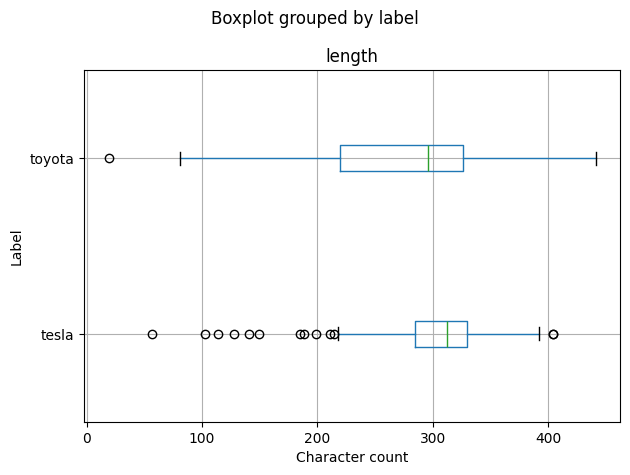

In [29]:
# crete boxplot to see distribution of counts by label
plt.figure(figsize=(8, 6))
combined.boxplot(column='length', by='label', vert=False)
plt.xlabel('Character count')
plt.ylabel('Label')
plt.tight_layout()
plt.show()

### clean and process text

In [30]:
# define function to tokenize text
def tokenize(text):
  return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [31]:
# check stopwords
stopwords = set(nltk.corpus.stopwords.words('english'))
list(stopwords)[:5]

['or', 'at', 'he', 'which', 'my']

In [32]:
# add tesla and toyota as stopwords, we do not want to see these words in the features
include_stopwords = {'tesla', 'toyota'}
stopwords |= include_stopwords

In [33]:
# define function to remove stopwords
def remove_stop(tokens):
  return [t for t in tokens if t.lower() not in stopwords]

In [34]:
# create pipeline to lowercase, tokenize and remove stop words
pipeline = [str.lower, tokenize, remove_stop]

# define function to feed text data through the pipeline and return cleaned tokens
def prepare(text, pipeline):

  # convert text to string if it's not already a string (for float types)
  text = str(text)

  tokens = text
  for transform in pipeline:
    tokens = transform(tokens)
  return tokens

In [35]:
combined['tokens'] = combined['text'].apply(prepare, pipeline=pipeline)
combined.head()

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length,tokens
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other ...,Ever since Tesla started rolling out Full Self...,https://cleantechnica.com/2024/04/23/tesla-ful...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-24T03:55:41Z,Sign up for daily news updates from CleanTechn...,tesla,Tesla “Full Self Driving” Could Come To Other ...,328.0,"[full, self, driving, could, come, countries, ..."
1,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,More Than 3× As Many Tesla Model Y Sales As Te...,"Tesla’s just had a tough quarter, including in...",https://cleantechnica.com/2024/04/19/more-than...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-20T03:57:24Z,Sign up for daily news updates from CleanTechn...,tesla,More Than 3× As Many Tesla Model Y Sales As Te...,346.0,"[many, model, sales, model, sales, usa, 1st, q..."
2,"{'id': None, 'name': 'CleanTechnica'}",Paul Fosse,Tesla Surprises Investors With A Tiny Y & A Ti...,A lot has been written about the Tesla’s next-...,https://cleantechnica.com/2024/04/23/tesla-sur...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-24T01:56:23Z,Sign up for daily news updates from CleanTechn...,tesla,Tesla Surprises Investors With A Tiny Y & A Ti...,333.0,"[surprises, investors, tiny, tiny, soon, year,..."
3,"{'id': None, 'name': 'CleanTechnica'}",Carolyn Fortuna,The Revisionist Language That Tesla Used In Th...,"The Tesla, Inc. Q1 2024 earnings call was fasc...",https://cleantechnica.com/2024/04/26/the-revis...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-26T19:24:10Z,Sign up for daily news updates from CleanTechn...,tesla,The Revisionist Language That Tesla Used In Th...,330.0,"[revisionist, language, used, q1, earnings, ca..."
4,"{'id': 'techcrunch', 'name': 'TechCrunch'}",Paul Sawers,French startup FlexAI exits stealth with $30M ...,A French startup has raised a hefty seed inves...,https://techcrunch.com/2024/04/23/french-start...,https://s.yimg.com/ny/api/res/1.2/V7FcJP2rJb.Y...,2024-04-24T05:37:28Z,A French startup has raised a hefty seed inves...,tesla,French startup FlexAI exits stealth with $30M ...,232.0,"[french, startup, flexai, exits, stealth, 30m,..."


In [36]:
combined[:1]

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length,tokens
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other ...,Ever since Tesla started rolling out Full Self...,https://cleantechnica.com/2024/04/23/tesla-ful...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-24T03:55:41Z,Sign up for daily news updates from CleanTechn...,tesla,Tesla “Full Self Driving” Could Come To Other ...,328.0,"[full, self, driving, could, come, countries, ..."


In [37]:
# get the number of tokens as a field
combined['num_tokens'] = combined['tokens'].map(len)
combined[:1]

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length,tokens,num_tokens
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other ...,Ever since Tesla started rolling out Full Self...,https://cleantechnica.com/2024/04/23/tesla-ful...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-24T03:55:41Z,Sign up for daily news updates from CleanTechn...,tesla,Tesla “Full Self Driving” Could Come To Other ...,328.0,"[full, self, driving, could, come, countries, ...",32


### EDA and visualizations

In [38]:
# seperate records based on labels in 2 different series
tesla_tokens = combined.loc[combined['label'] == 'tesla', 'tokens']
toyota_tokens = combined.loc[combined['label'] == 'toyota', 'tokens']

tesla_tokens[:5]

0    [full, self, driving, could, come, countries, ...
1    [many, model, sales, model, sales, usa, 1st, q...
2    [surprises, investors, tiny, tiny, soon, year,...
3    [revisionist, language, used, q1, earnings, ca...
4    [french, startup, flexai, exits, stealth, 30m,...
Name: tokens, dtype: object

In [39]:
# flatten each so we can get all tokens in each df into a single list
tesla_flat_tokens = [word for sublist in tesla_tokens for word in sublist]
toyota_flat_tokens = [word for sublist in toyota_tokens for word in sublist]

tesla_flat_tokens[:5]

['full', 'self', 'driving', 'could', 'come']

In [40]:
# 2828 tokens
len(tesla_flat_tokens)

2828

In [41]:
# get count of each word 
tesla_word_counts = Counter(tesla_flat_tokens)
toyota_word_counts = Counter(toyota_flat_tokens)

# check the first 5 records
dict(list(tesla_word_counts.items())[:5])

{'full': 10, 'self': 3, 'driving': 3, 'could': 7, 'come': 3}

In [42]:
# get the 10 most common words for both each
print(tesla_word_counts.most_common(10))

[('musk', 34), ('elon', 29), ('ev', 24), ('model', 22), ('earnings', 21), ('company', 20), ('china', 19), ('electric', 18), ('cybertruck', 18), ('fsd', 16)]


In [43]:
print(toyota_word_counts.most_common(10))

[('car', 47), ('new', 24), ('hybrid', 23), ('cars', 22), ('first', 14), ('year', 13), ('electric', 13), ('one', 12), ('vehicles', 12), ('us', 11)]


In [44]:
# convert counter type to list so we can plot
top_tesla_words = list(tesla_word_counts.most_common(10))
top_toyota_words = list(toyota_word_counts.most_common(10))

In [45]:
# get words and their count from the list
tesla_words, tesla_counts = zip(*top_tesla_words)
toyota_words, toyota_counts = zip(*top_toyota_words)

print(tesla_words)
print(tesla_counts)

('musk', 'elon', 'ev', 'model', 'earnings', 'company', 'china', 'electric', 'cybertruck', 'fsd')
(34, 29, 24, 22, 21, 20, 19, 18, 18, 16)


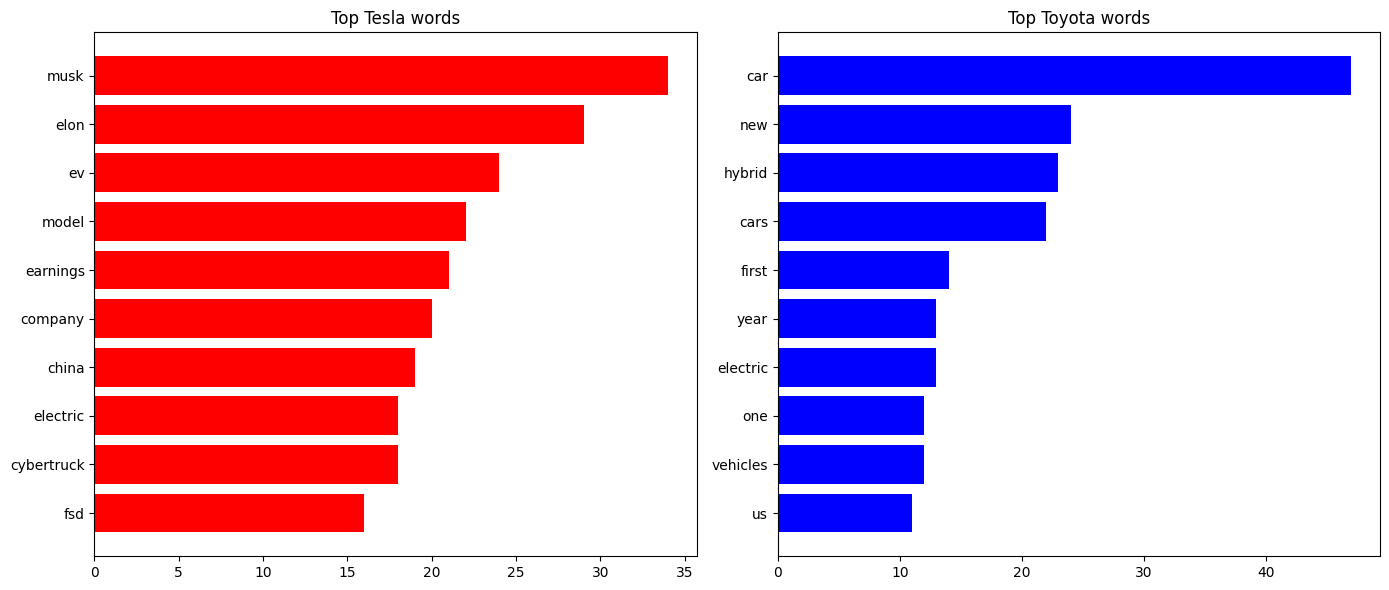

In [46]:
# create 2 subplots, next to eachother
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# plot tesla words, highest counts at the top
ax[0].barh(tesla_words, tesla_counts, color='red')
ax[0].invert_yaxis()
ax[0].set_title('Top Tesla words')

# do the same for toyota
ax[1].barh(toyota_words, toyota_counts, color='blue')
ax[1].invert_yaxis()  # Highest counts at the top
ax[1].set_title('Top Toyota words')

# show the plot, tight layout so fit is better
plt.tight_layout()
plt.show()

In [47]:
# now to get the descriptive statistics, define the function created in earlier assignments
def descriptive_stats(tokens, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    # length of num tokens list
    num_tokens = len(tokens)

    # length of unique tokens in list
    num_unique_tokens = len(set(tokens))

    # unique tokens divided by total tokens to see diversity
    lexical_diversity = num_unique_tokens / num_tokens

    # get sum of characters
    sum = 0
    for word in tokens:
        for char in word:
            sum += 1

    num_characters = sum
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

In [48]:
# Split the DataFrame based on the "label" field
tesla_df = combined[combined['label'] == 'tesla']
toyota_df = combined[combined['label'] == 'toyota']

# Combine all the lists in the "tokens" field into one giant list for each DataFrame
tesla_tokens = [item for sublist in tesla_df['tokens'] for item in sublist]
toyota_tokens = [item for sublist in toyota_df['tokens'] for item in sublist]

In [49]:
tesla_tokens[:5]

['full', 'self', 'driving', 'could', 'come']

In [50]:
# apply descriptive stats to the tesla tokens
descriptive_stats(tesla_tokens)

There are 2828 tokens in the data.
There are 1424 unique tokens in the data.
There are 17430 characters in the data.
The lexical diversity is 0.504 in the data.


[2828, 1424, 0.5035360678925035, 17430]

In [51]:
# do the same for toyota
descriptive_stats(toyota_tokens)

There are 2774 tokens in the data.
There are 1527 unique tokens in the data.
There are 16696 characters in the data.
The lexical diversity is 0.550 in the data.


[2774, 1527, 0.5504686373467916, 16696]

## Part 2: Classification Models

In [52]:
combined.head()

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length,tokens,num_tokens
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other ...,Ever since Tesla started rolling out Full Self...,https://cleantechnica.com/2024/04/23/tesla-ful...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-24T03:55:41Z,Sign up for daily news updates from CleanTechn...,tesla,Tesla “Full Self Driving” Could Come To Other ...,328.0,"[full, self, driving, could, come, countries, ...",32
1,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,More Than 3× As Many Tesla Model Y Sales As Te...,"Tesla’s just had a tough quarter, including in...",https://cleantechnica.com/2024/04/19/more-than...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-20T03:57:24Z,Sign up for daily news updates from CleanTechn...,tesla,More Than 3× As Many Tesla Model Y Sales As Te...,346.0,"[many, model, sales, model, sales, usa, 1st, q...",31
2,"{'id': None, 'name': 'CleanTechnica'}",Paul Fosse,Tesla Surprises Investors With A Tiny Y & A Ti...,A lot has been written about the Tesla’s next-...,https://cleantechnica.com/2024/04/23/tesla-sur...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-24T01:56:23Z,Sign up for daily news updates from CleanTechn...,tesla,Tesla Surprises Investors With A Tiny Y & A Ti...,333.0,"[surprises, investors, tiny, tiny, soon, year,...",29
3,"{'id': None, 'name': 'CleanTechnica'}",Carolyn Fortuna,The Revisionist Language That Tesla Used In Th...,"The Tesla, Inc. Q1 2024 earnings call was fasc...",https://cleantechnica.com/2024/04/26/the-revis...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-26T19:24:10Z,Sign up for daily news updates from CleanTechn...,tesla,The Revisionist Language That Tesla Used In Th...,330.0,"[revisionist, language, used, q1, earnings, ca...",30
4,"{'id': 'techcrunch', 'name': 'TechCrunch'}",Paul Sawers,French startup FlexAI exits stealth with $30M ...,A French startup has raised a hefty seed inves...,https://techcrunch.com/2024/04/23/french-start...,https://s.yimg.com/ny/api/res/1.2/V7FcJP2rJb.Y...,2024-04-24T05:37:28Z,A French startup has raised a hefty seed inves...,tesla,French startup FlexAI exits stealth with $30M ...,232.0,"[french, startup, flexai, exits, stealth, 30m,...",25


In [53]:
# Preview format of text
combined["description"].head()

0    Ever since Tesla started rolling out Full Self...
1    Tesla’s just had a tough quarter, including in...
2    A lot has been written about the Tesla’s next-...
3    The Tesla, Inc. Q1 2024 earnings call was fasc...
4    A French startup has raised a hefty seed inves...
Name: description, dtype: object

In [54]:
# Loop through all columns in the DataFrame
for column in combined.columns:
    if combined[column].dtype == object:  
        combined[column] = combined[column].str.lower() 

# Preview upd format of text
combined["description"].head()

0    ever since tesla started rolling out full self...
1    tesla’s just had a tough quarter, including in...
2    a lot has been written about the tesla’s next-...
3    the tesla, inc. q1 2024 earnings call was fasc...
4    a french startup has raised a hefty seed inves...
Name: description, dtype: object

In [55]:
# First want to create a sentiment analyzes between the two automanufacturers

# Split the DataFrame into two groups based on the presence of "Tesla" or "Toyota"
tesla_df = combined[combined['title'].str.contains('tesla', case=False, na=False)]
toyota_df = combined[combined['title'].str.contains('toyota', case=False, na=False)]

# Define a function to handle sentiment analysis, with a check for non-string values
def analyze_sentiment(text):
    if isinstance(text, str):
        analysis = TextBlob(text)
        return analysis.sentiment.polarity
    else:
        return None

# Apply the sentiment analysis function, handling non-string values
tesla_df['sentiment'] = tesla_df['description'].apply(analyze_sentiment)
toyota_df['sentiment'] = toyota_df['description'].apply(analyze_sentiment)

# Function to calculate statistics
def calculate_stats(df):
    valid_sentiments = df['sentiment'].dropna()
    sentiment_range = valid_sentiments.max() - valid_sentiments.min()
    sentiment_min = valid_sentiments.min()
    sentiment_max = valid_sentiments.max()
    sentiment_median = valid_sentiments.median()
    sentiment_mean = valid_sentiments.mean()
    return sentiment_range, sentiment_min, sentiment_max, sentiment_median, sentiment_mean

# Calculate stats for Tesla
tesla_range, tesla_min, tesla_max, tesla_median, tesla_mean = calculate_stats(tesla_df)
# Calculate stats for Toyota
toyota_range, toyota_min, toyota_max, toyota_median, toyota_mean = calculate_stats(toyota_df)

# Display the results
print("Tesla DataFrame:")
tesla_df
print(f"Sentiment Range: {tesla_range}, Min: {tesla_min}, Max: {tesla_max}, Median: {tesla_median}, Mean: {tesla_mean}")

print("\nToyota DataFrame:")
toyota_df
print(f"Sentiment Range: {toyota_range}, Min: {toyota_min}, Max: {toyota_max}, Median: {toyota_median}, Mean: {toyota_mean}")

Tesla DataFrame:
Sentiment Range: 0.8722222222222222, Min: -0.12222222222222219, Max: 0.75, Median: 0.15536616161616162, Mean: 0.15226958144368857

Toyota DataFrame:
Sentiment Range: 1.4457070707070707, Min: -1.0, Max: 0.4457070707070707, Median: 0.014062500000000002, Mean: 0.02981079395141895


/var/folders/gy/c9ysryks527gqrvc9m2d1pn80000gn/T/ipykernel_14174/2731432201.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tesla_df['sentiment'] = tesla_df['description'].apply(analyze_sentiment)
/var/folders/gy/c9ysryks527gqrvc9m2d1pn80000gn/T/ipykernel_14174/2731432201.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toyota_df['sentiment'] = toyota_df['description'].apply(analyze_sentiment)


In [56]:
# Add column to indicate if 'Tesla', 'Toyota', or both are mentioned in the title or description
def label_manufacturer(row):
    title = row['title']
    description = row['description']
    
    title_contains_tesla = isinstance(title, str) and 'tesla' in title.lower()
    title_contains_toyota = isinstance(title, str) and 'toyota' in title.lower()
    description_contains_tesla = isinstance(description, str) and 'tesla' in description.lower()
    description_contains_toyota = isinstance(description, str) and 'toyota' in description.lower()
    
    if (title_contains_tesla and title_contains_toyota) or (description_contains_tesla and description_contains_toyota):
        return 'Both'
    elif title_contains_tesla or description_contains_tesla:
        return 'Tesla'
    elif title_contains_toyota or description_contains_toyota:
        return 'Toyota'
    else:
        return None

combined['manufacturer'] = combined.apply(label_manufacturer, axis=1)

# Count rows with both 'Tesla' and 'Toyota'
both_count = combined[combined['manufacturer'] == 'Both'].shape[0]

print(f"Number of rows with both 'Tesla' and 'Toyota' present: {both_count}")

Number of rows with both 'Tesla' and 'Toyota' present: 1


In [57]:
# Want to see class balance between the two manufacturers
print(combined['manufacturer'].value_counts())

manufacturer
Tesla     61
Toyota    34
Both       1
Name: count, dtype: int64


In [58]:
# Remove articles that reference both
combined = combined[combined["manufacturer"] != "Both"]

# Want to see class balance between the two manufacturers
print(combined['manufacturer'].value_counts())

manufacturer
Tesla     61
Toyota    34
Name: count, dtype: int64


In [59]:
# Function to remove specific words from a text
def remove_words(text, words):
    if isinstance(text, str):
        pattern = re.compile(r'\b(' + '|'.join(words) + r')\b', flags=re.IGNORECASE)
        return pattern.sub('', text)
    return text

# Indicate specifc words to remove from the description column
words_to_remove = ['tesla', 'toyota', 'teslas', 'toyotas']
combined['description'] = combined['description'].apply(lambda x: remove_words(x, words_to_remove))

In [60]:
def preprocess_data(df):
    # Create a binary label for classification
    df['label'] = df['title'].apply(lambda x: 'Tesla' if 'tesla' in x.lower() else 'Toyota' if 'toyota' in x.lower() else None)
    # Drop rows where label is None
    df = df.dropna(subset=['label'])
    # Ensure all descriptions are strings and handle NaN values
    df['description'] = df['description'].fillna('').astype(str)
    return df

def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    # Predict probabilities on the test data
    y_pred_proba = model.predict_proba(X_test)
    # Predict on the test data
    y_pred = model.predict(X_test)
    # Print the accuracy and classification report
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(classification_report(y_test, y_pred, target_names=['Tesla', 'Toyota']))
    # Plot confusion matrix
    plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['Tesla', 'Toyota'])
    plt.show()
    # Plot AUC-ROC curve
    plot_auc_roc_curve(y_test, y_pred_proba)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def plot_auc_roc_curve(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Define functions for each classifier
def logistic_regression(X_train, X_test, y_train, y_test):
    model = LogisticRegression()
    train_and_evaluate(model, X_train, X_test, y_train, y_test)

def svm_classifier(X_train, X_test, y_train, y_test):
    model = SVC(kernel='linear', probability=True)
    train_and_evaluate(model, X_train, X_test, y_train, y_test)

def random_forest(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(random_state=42)
    train_and_evaluate(model, X_train, X_test, y_train, y_test)

def naive_bayes(X_train, X_test, y_train, y_test):
    model = MultinomialNB()
    train_and_evaluate(model, X_train, X_test, y_train, y_test)

def knn_classifier(X_train, X_test, y_train, y_test):
    model = KNeighborsClassifier()
    train_and_evaluate(model, X_train, X_test, y_train, y_test)

def gradient_boosting(X_train, X_test,y_train, y_test):
    model = GradientBoostingClassifier(random_state=42)
    train_and_evaluate(model, X_train, X_test, y_train, y_test)

def adaboost(X_train, X_test, y_train, y_test):
    model = AdaBoostClassifier(random_state=42)
    train_and_evaluate(model, X_train, X_test, y_train, y_test)

def decision_tree(X_train, X_test, y_train, y_test):
    model = DecisionTreeClassifier(random_state=42)
    train_and_evaluate(model, X_train, X_test, y_train, y_test)

def xgboost(X_train, X_test, y_train, y_test):
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    train_and_evaluate(model, X_train, X_test, y_train, y_test)

# Preprocess the data
combined = preprocess_data(combined)

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Vectorize the description column
X = tfidf_vectorizer.fit_transform(combined['description'])

# Encode the labels (Tesla=0, Toyota=1)
y = combined['manufacturer'].apply(lambda x: 0 if x == 'Tesla' else 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/var/folders/gy/c9ysryks527gqrvc9m2d1pn80000gn/T/ipykernel_14174/2206601609.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['description'] = df['description'].fillna('').astype(str)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Logistic Regression:
Accuracy: 0.8125
              precision    recall  f1-score   support

       Tesla       0.81      1.00      0.90        13
      Toyota       0.00      0.00      0.00         3

    accuracy                           0.81        16
   macro avg       0.41      0.50      0.45        16
weighted avg       0.66      0.81      0.73        16

Confusion matrix, without normalization
[[13  0]
 [ 3  0]]


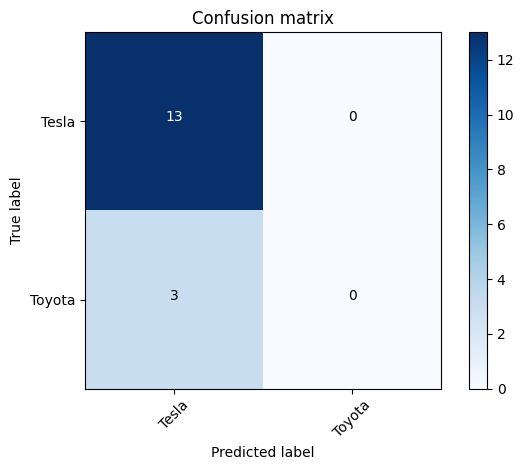

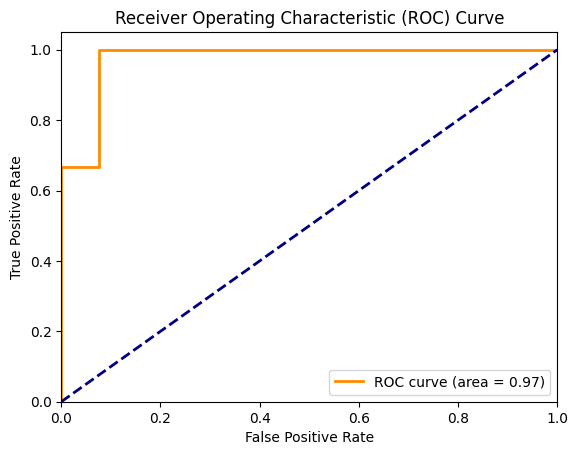

In [61]:
# Train & evaluate using different models
print("Logistic Regression:")
logistic_regression(X_train, X_test, y_train, y_test)


Support Vector Machine:
Accuracy: 0.8125
              precision    recall  f1-score   support

       Tesla       0.81      1.00      0.90        13
      Toyota       0.00      0.00      0.00         3

    accuracy                           0.81        16
   macro avg       0.41      0.50      0.45        16
weighted avg       0.66      0.81      0.73        16

Confusion matrix, without normalization
[[13  0]
 [ 3  0]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

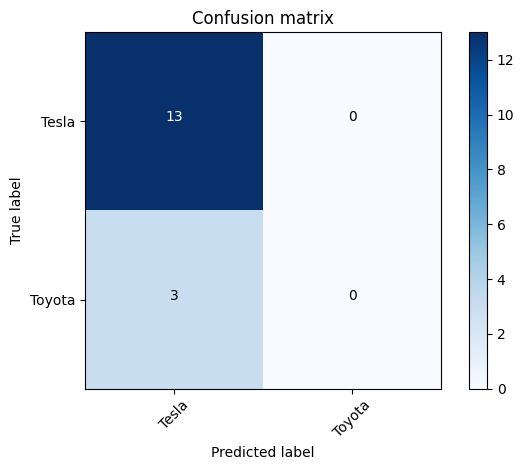

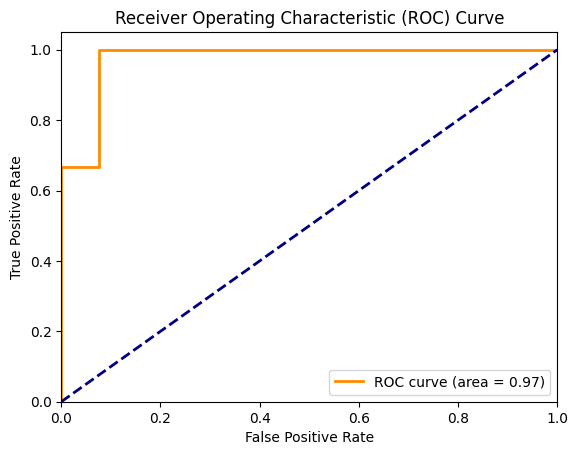

In [62]:
print("\nSupport Vector Machine:")
svm_classifier(X_train, X_test, y_train, y_test)


Random Forest:
Accuracy: 0.8125
              precision    recall  f1-score   support

       Tesla       0.81      1.00      0.90        13
      Toyota       0.00      0.00      0.00         3

    accuracy                           0.81        16
   macro avg       0.41      0.50      0.45        16
weighted avg       0.66      0.81      0.73        16

Confusion matrix, without normalization
[[13  0]
 [ 3  0]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

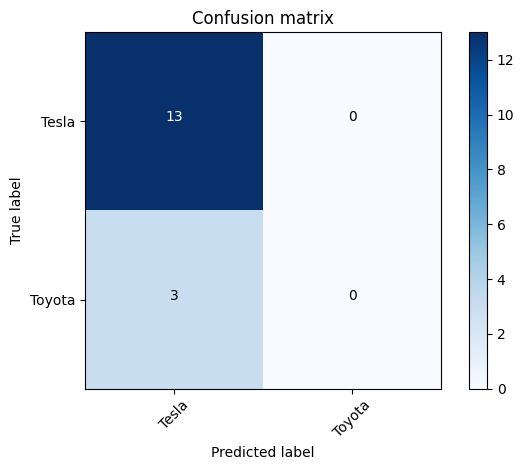

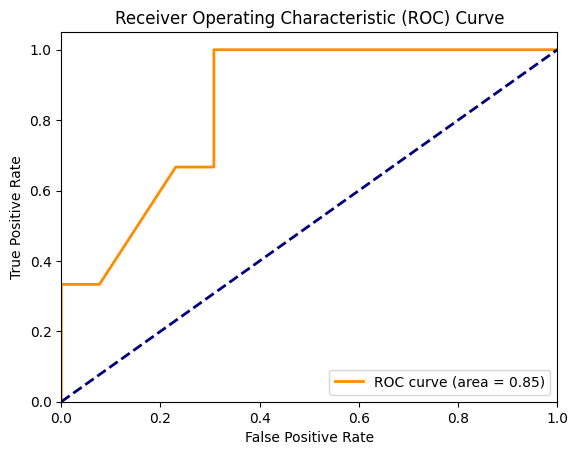

In [63]:
print("\nRandom Forest:")
random_forest(X_train, X_test, y_train, y_test)


Naive Bayes:
Accuracy: 0.8125
              precision    recall  f1-score   support

       Tesla       0.81      1.00      0.90        13
      Toyota       0.00      0.00      0.00         3

    accuracy                           0.81        16
   macro avg       0.41      0.50      0.45        16
weighted avg       0.66      0.81      0.73        16

Confusion matrix, without normalization
[[13  0]
 [ 3  0]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

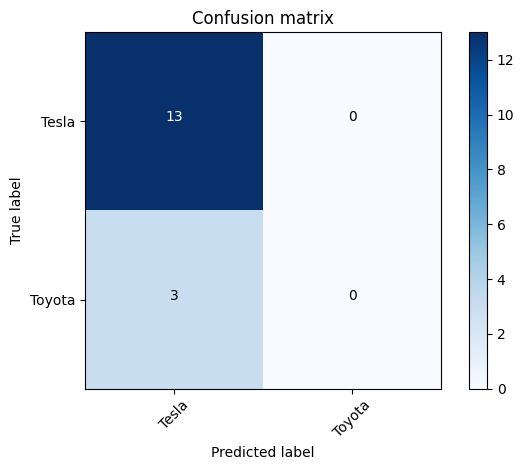

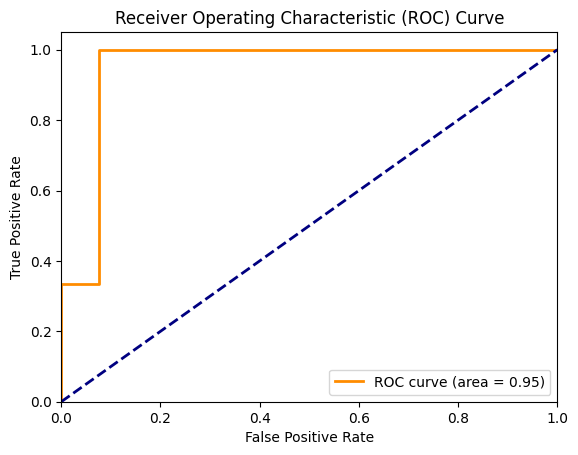

In [64]:
print("\nNaive Bayes:")
naive_bayes(X_train, X_test, y_train, y_test)


K-Nearest Neighbors:
Accuracy: 0.75
              precision    recall  f1-score   support

       Tesla       0.80      0.92      0.86        13
      Toyota       0.00      0.00      0.00         3

    accuracy                           0.75        16
   macro avg       0.40      0.46      0.43        16
weighted avg       0.65      0.75      0.70        16

Confusion matrix, without normalization
[[12  1]
 [ 3  0]]


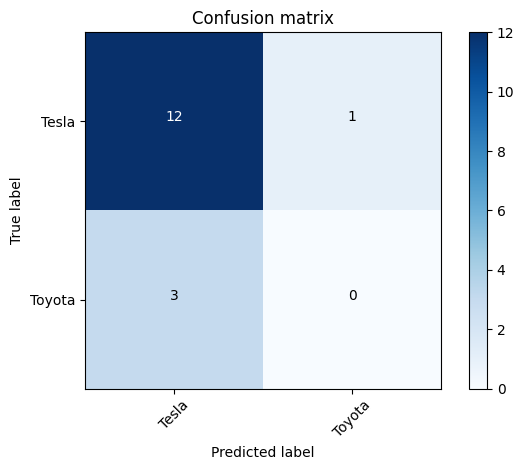

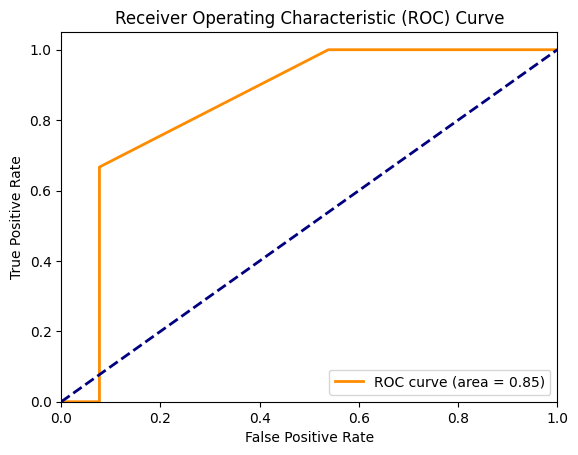

In [65]:
print("\nK-Nearest Neighbors:")
knn_classifier(X_train, X_test, y_train, y_test)


Gradient Boosting:
Accuracy: 0.6875
              precision    recall  f1-score   support

       Tesla       0.83      0.77      0.80        13
      Toyota       0.25      0.33      0.29         3

    accuracy                           0.69        16
   macro avg       0.54      0.55      0.54        16
weighted avg       0.72      0.69      0.70        16

Confusion matrix, without normalization
[[10  3]
 [ 2  1]]


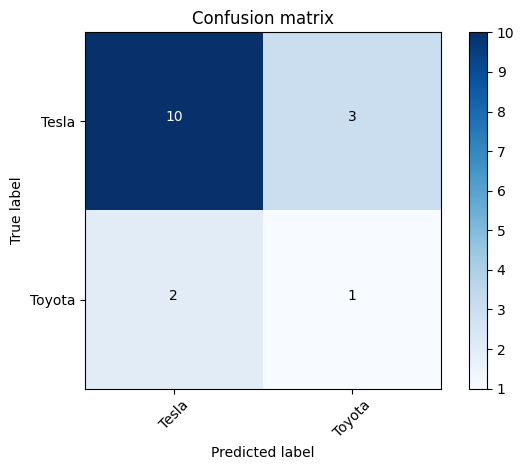

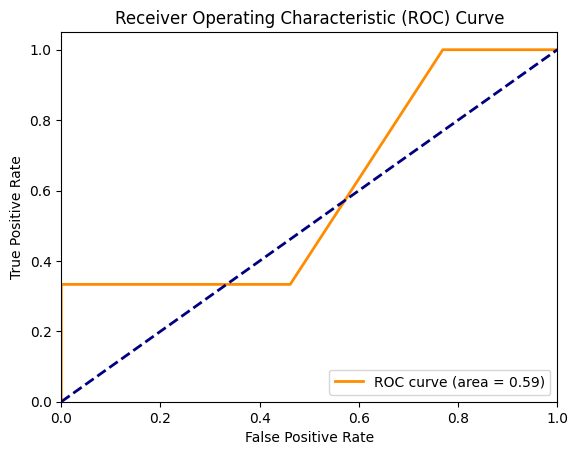

In [66]:
print("\nGradient Boosting:")
gradient_boosting(X_train, X_test, y_train, y_test)


AdaBoost:


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.75
              precision    recall  f1-score   support

       Tesla       0.85      0.85      0.85        13
      Toyota       0.33      0.33      0.33         3

    accuracy                           0.75        16
   macro avg       0.59      0.59      0.59        16
weighted avg       0.75      0.75      0.75        16

Confusion matrix, without normalization
[[11  2]
 [ 2  1]]


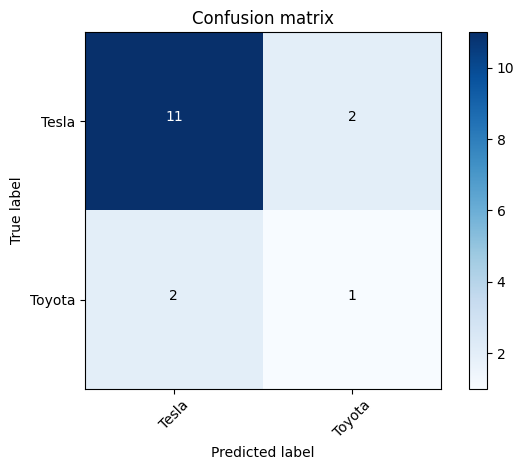

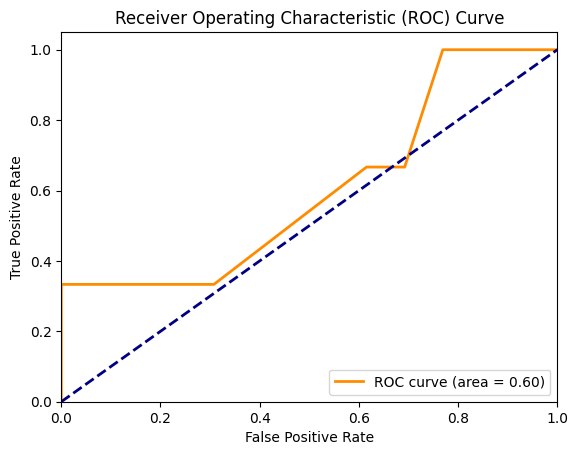

In [67]:
print("\nAdaBoost:")
adaboost(X_train, X_test, y_train, y_test)


Decision Tree:
Accuracy: 0.625
              precision    recall  f1-score   support

       Tesla       0.82      0.69      0.75        13
      Toyota       0.20      0.33      0.25         3

    accuracy                           0.62        16
   macro avg       0.51      0.51      0.50        16
weighted avg       0.70      0.62      0.66        16

Confusion matrix, without normalization
[[9 4]
 [2 1]]


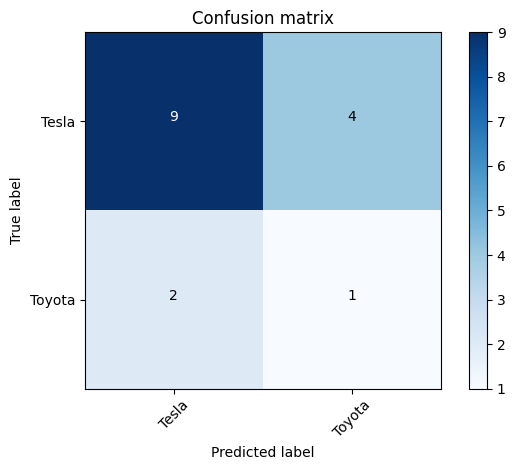

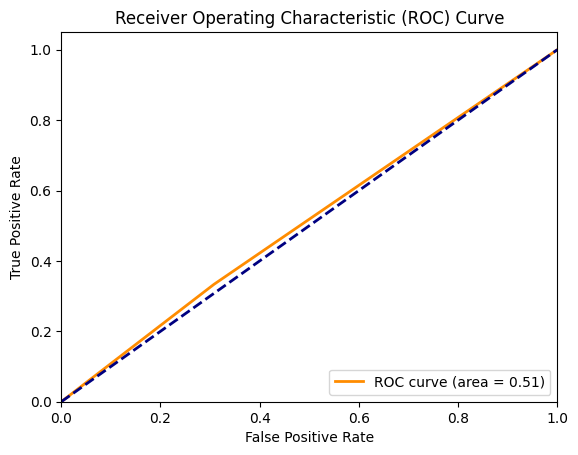

In [68]:
print("\nDecision Tree:")
decision_tree(X_train, X_test, y_train, y_test)


XGBoost:
Accuracy: 0.75
              precision    recall  f1-score   support

       Tesla       0.85      0.85      0.85        13
      Toyota       0.33      0.33      0.33         3

    accuracy                           0.75        16
   macro avg       0.59      0.59      0.59        16
weighted avg       0.75      0.75      0.75        16

Confusion matrix, without normalization
[[11  2]
 [ 2  1]]


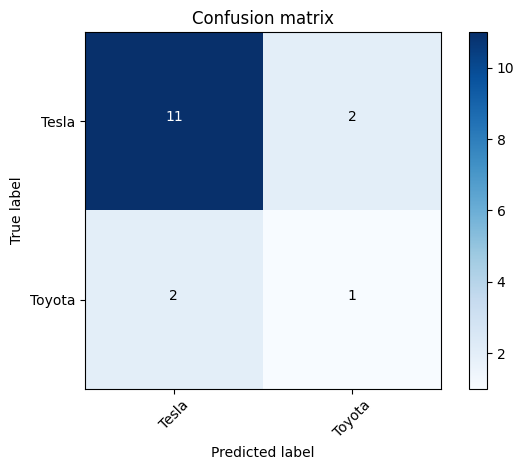

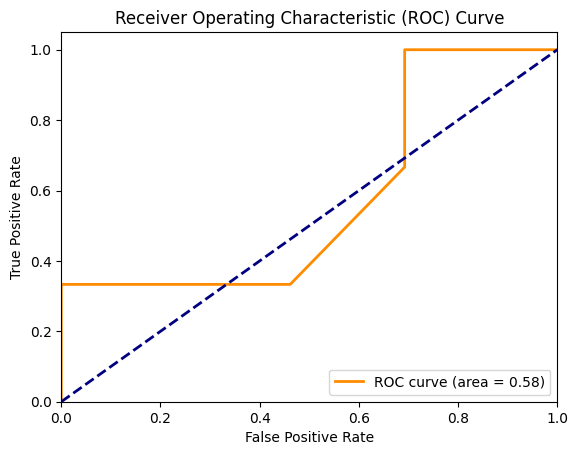

In [69]:
print("\nXGBoost:")
xgboost(X_train, X_test, y_train, y_test)

### Try to classify new text

In [73]:
# Train the AdaBoost model
model = AdaBoostClassifier(random_state=42)
model.fit(X, y)

# Function to classify a new text description
def classify_text(description, model, vectorizer):
    # Preprocess the description
    description = remove_words(description, words_to_remove)
    # Transform the description using the TF-IDF vectorizer
    description_vector = vectorizer.transform([description])
    # Predict the class
    prediction = model.predict(description_vector)
    # Return the prediction label
    return 'Tesla' if prediction[0] == 0 else 'Toyota'

# Function to interactively get user input and classify
def get_user_input():
    description = input("Enter description: ")
    prediction = classify_text(description, model, tfidf_vectorizer)
    print(f"The description is related to: {prediction}")

# Get user input and classify
get_user_input()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


The description is related to: Tesla
